In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import requests
from torch.autograd import Variable


c:\Users\sonor\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length=5):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size * 3, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 3, hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size * 1)
        self.fc2 = nn.Linear(hidden_size * 1, num_classes)
        # self.fc3 = nn.Linear(hidden_size * 1, hidden_size // 2)
        # self.fc4 = nn.Linear(hidden_size // 2, num_classes)



    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size * 3))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size * 3))

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size * 3)
        out = self.fc(h_out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

In [3]:
seq_length = 12
lstm = LSTM(1, 1, 1, 1, seq_length)
lstm.load_state_dict(torch.load("models/energy_usage_predictor.pth"))

lstm.eval()


def sliding_windows(data, seq_length, first_sequence=True):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        if first_sequence:
            x.append(_x)
            first_sequence = False
        y.append(_y)

    return np.array(x), np.array(y)

# Get the last 12 points of 10 minute chunks (so if every 5 seconds, that is 2400) and predict what the prices will be
response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit=100000")
usage = response.json()
ten_minute_averages = {"timestamp": [], "power": []}

for i in range(0, len(usage['data']), 85):
    values = usage['data'][i:i+120]
    power = [value['power'] for value in values]
    ten_minute_averages["timestamp"].append(values[0]['timestamp'])
    ten_minute_averages["power"].append(np.average(power) * 1000)
    

power = ten_minute_averages["power"]
power = [[i] for i in power]
print(len(power))
power = np.array(power)

sc = MinMaxScaler()
power = sc.fit_transform(power)
testNewX, testNewY = sliding_windows(power, seq_length)

tensorX = torch.Tensor(testNewX)

first_prediction = lstm(tensorX)

1177


In [4]:
predictions = []
first_prediction = lstm(tensorX)

for i in range(len(testNewY)):
    tensorX = torch.Tensor(testNewX)
    first_prediction = lstm(tensorX)
    testNewX[0][0] = first_prediction.data.numpy()[0][0]
    testNewX = np.roll(testNewX, shift=-1)
    predictions.append(sc.inverse_transform(first_prediction.data.numpy())[0][0])

[[-42992.59362221]
 [-39750.35475095]
 [-39765.19295375]
 ...
 [  6431.05556965]
 [  6097.61534929]
 [  5545.54175536]]


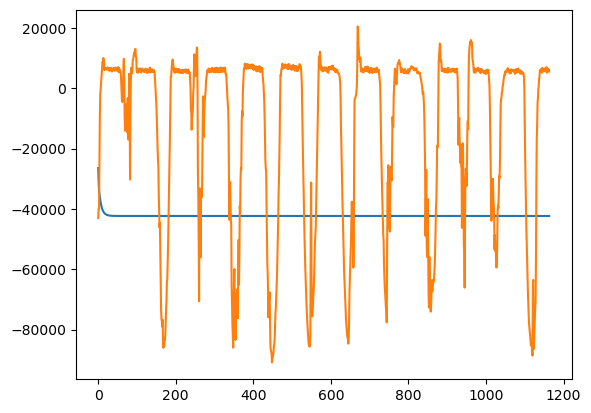

In [5]:
plt.plot(predictions)
print(sc.inverse_transform(testNewY))
plt.plot(sc.inverse_transform(testNewY))
plt.show()